<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>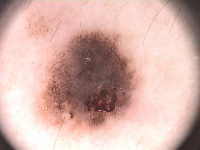</td><td>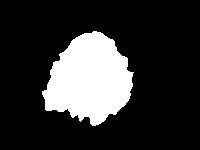</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [2]:
def set_seed(seed):
    import torch
    import numpy as np
    import random
    import os
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(66)

In [3]:
! wget https://www.dropbox.com/s/wcsx5adpj5ye9va/PH2Dataset.rar

--2021-05-10 10:39:13--  https://www.dropbox.com/s/wcsx5adpj5ye9va/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wcsx5adpj5ye9va/PH2Dataset.rar [following]
--2021-05-10 10:39:13--  https://www.dropbox.com/s/raw/wcsx5adpj5ye9va/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucff1a37471fb940deaef165bef1.dl.dropboxusercontent.com/cd/0/inline/BOO-lfabRFBz21tDq4uoE30HCzh7sJfIXjhuxiS7xJ5SVulg-UJ9OSZwSTUaP4e24R1OJqXXrEpPRtZ0Sn3YdaG3gTLWTfZoLsUznhuooq4oNZJ8j4Fr-V0npNu0Cm95fUvIQO8Wkctrfe5r8TBXq5LY/file# [following]
--2021-05-10 10:39:14--  https://ucff1a37471fb940deaef165bef1.dl.dropboxusercontent.com/cd/0/inline/BOO-lfabRFBz21tDq4uoE30HCzh7sJfIXjhuxiS7xJ5SVulg-UJ9OSZwSTUaP4e24R1OJqXXrEpPRtZ0S

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [5]:
import torch
torch.cuda.empty_cache()

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [7]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [9]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

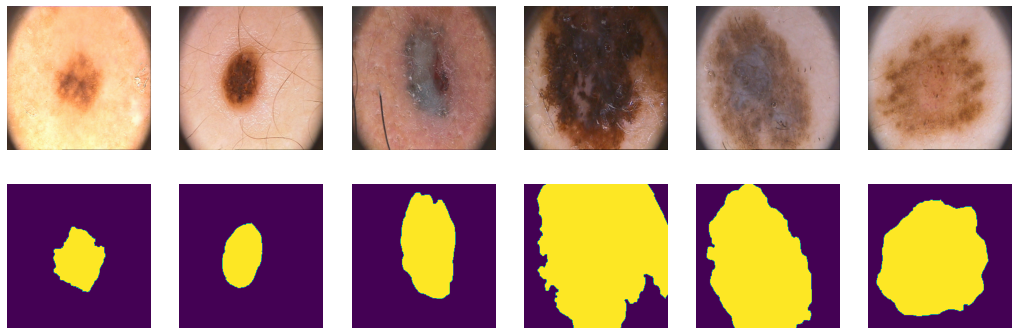

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();


Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [13]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

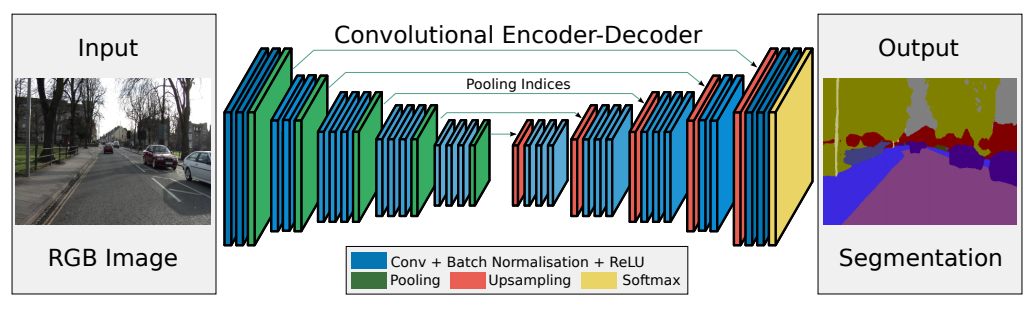

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
            )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
            )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b =  self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))
        
        # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_real, y_pred):
    loss = torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))/256/256
    return loss
    # please don't use nn.BCELoss. write it from scratch

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, train_losses, val_losses):
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch=X_batch.to(device)
            Y_batch=Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss=bce_loss(Y_batch, Y_pred)
            #print(loss) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        # show intermediate results
        model.eval()  # testing mode torch.round(nn.Sigmoid()(model(X_batch.to(device)))) 
        Y_hat = torch.round(nn.Sigmoid()(model(X_val.to(device)))).detach().to('cpu')# detach and put into cpu
        train_losses=np.append(train_losses, score_model(model, iou_pytorch, data_tr))
        val_losses=np.append(val_losses, score_model(model, iou_pytorch, data_val))
        # Visualize tools
        
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return train_losses, val_losses
        

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred=torch.round(nn.Sigmoid()(model(X_batch.to(device)))) 
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = SegNet().to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
max_epochs = 200
optim=torch.optim.Adam(model.parameters(),lr=0.0005)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

Это общий код для обучения моделей для отчета

In [ ]:
"""
Этот же код дальше будет в виде функции
model = SegNet().to(device)
max_epochs = 200
optim=torch.optim.Adam(model.parameters(),lr=0.0005)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)
print(score_model(model, iou_pytorch, data_tr))
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))
test_SegNet_bce=score_model(model, iou_pytorch, data_ts)
epochs=np.arange(1,201,1)
train_losses_SegNet_bce=train_losses
val_losses_SegNet_bce=val_losses
train_losses=np.array([])
val_losses=np.array([])
test_SegNet_bce=score_model(model, iou_pytorch, data_ts)
plt.plot(epochs, train_losses_SegNet_bce)
plt.plot(epochs, val_losses_SegNet_bce)
plt.show()
"""

Ответьте себе на вопрос: не переобучается ли моя модель?
Переобучилась.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [21]:
def dice_loss(y_real, y_pred):
    num = torch.sum(2 * Y_real*Y_pred)
    den = torch.sum(Y_real+Y_pred)
    res = 1 - num/den / 256 / 256
    return res 

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

In [ ]:
max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=0.001)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [22]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    loss = torch.sum(((1-torch.clamp(y_pred,0,1))**gamma)*y_real*torch.log(eps+torch.clamp(y_pred,0,1))+
                       (1-y_real)*torch.log(eps+1-torch.clamp(y_pred,0,1))) # hint: torch.clamp
    return loss

In [ ]:
model_focal = SegNet().to(device)

In [ ]:
max_epochs = 100
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=0.0005)
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [23]:
from scipy.ndimage.morphology import distance_transform_edt as edt
def distance(img):
    dist = np.zeros_like(img)
    for i in range(len(img)):
        mask1 = img[i] > 0.5

        if mask1.any():
            mask2 = ~mask1

            dist1 = edt(mask1)
            dist2 = edt(mas2)

            dist[i] = dist1 + dist2
    return dist

def hausdorff_loss(y_real, y_pred, alpha=2.0):
    dist_pred = torch.from_numpy(distance(y_pred.cpu().numpy())).float()
    dist_real = torch.from_numpy(distance(y_real.cpu().numpy())).float()
    pred_error = (dist_pred - dist_real) ** 2
    dist = dist_pred ** alpha + dist_real ** alpha
    loss = (pred_error * dist).mean()
    return loss

In [ ]:
model_Hausdorff = SegNet().to(device)

In [ ]:
max_epochs = 20
optimaizer = torch.optim.Adam(model_Hausdorff.parameters(), lr=0.00005)
train(model_Hausdorff, optimaizer, hausdorff_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_Hausdorff, iou_pytorch, data_ts)

0.6660000205039978

In [ ]:
model_Hausdorff.cpu()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

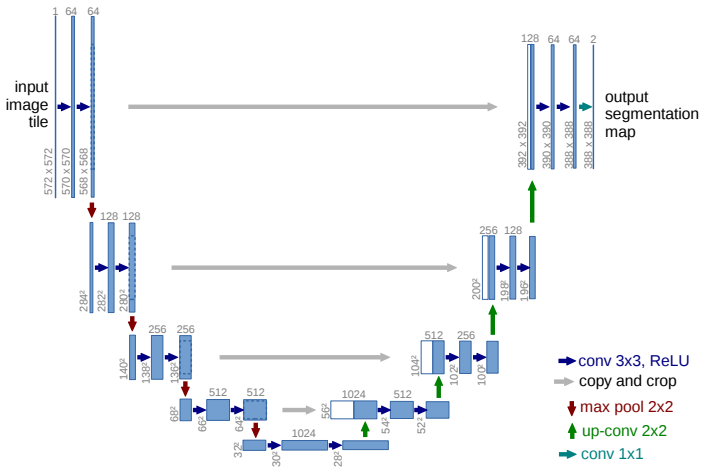

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [24]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
            )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.upsample1 = nn.Upsample(scale_factor=2)# nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.upsample2 = nn.Upsample(scale_factor=2)# nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.upsample3 = nn.Upsample(scale_factor=2)# nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
            )

    def forward(self, x):

        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b =  self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat((b, e3),1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat((d0, e2),1)))
        d2 = self.dec_conv2(self.upsample1(torch.cat((d1, e1),1)))
        d3 = self.dec_conv3(self.upsample1(torch.cat((d2, e0),1)))
        return d3

In [ ]:
unet_model = UNet().to(device)

In [ ]:
max_epochs = 20
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=0.0005)
train(unet_model, optimaizer, hausdorff_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.5280000150203705

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            )
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
            )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
            )

    def forward(self, x):

        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b =  self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat((b, e3),1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat((d0, e2),1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat((d1, e1),1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat((d2, e0),1)))
        return d3


In [ ]:
unet2_model = UNet2().to(device)

In [ ]:
max_epochs = 50
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=0.0005)
train(unet2_model, optimaizer, hausdorff_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_ts)

0.7420000314712525

Сделайте вывод, какая из моделей лучше

Здесь пройдет обучение всех моделей со всеми имеющимися лоссами.

In [25]:
def global_train(model, max_epochs=50, loss_function=bce_loss, device=device, 
                 lr=0.0005, data_tr=data_tr, data_val=data_val, data_ts=data_ts, 
                 plot_result=True, print_result=True):
    torch.cuda.empty_cache()
    train_losses=np.array([])
    val_losses=np.array([])
    model = model.to(device)
    optim=torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses=train(model, optim, loss_function, max_epochs, data_tr, data_val, train_losses, val_losses)
    if print_result==True:
        print(score_model(model, iou_pytorch, data_tr))
        print(score_model(model, iou_pytorch, data_val))
        print(score_model(model, iou_pytorch, data_ts))
    test_loss=score_model(model, iou_pytorch, data_ts)
    epochs=np.arange(1, max_epochs+1, 1)
    test=score_model(model, iou_pytorch, data_ts)
    if plot_result==True:
        plt.plot(epochs, train_losses)
        plt.plot(epochs, val_losses)
        plt.show()
    return train_losses, val_losses, epochs, test_loss

train_losses, val_losses, epochs, test_losses - словари с данными о моделях, ключи - названия моделей с указанием лосса по типу 'SegNet_bce'

train_losses - IoU на тренировке во время обучения

val_losses - IoU на валидации во время обучения

epochs - np.array из эпох (np.arange(1, max_epochs+1, 1))

test_losses - IoU на тесте в конце обучения



In [29]:
train_losses={}
val_losses={}
epochs={}
test_losses={}

In [26]:
# Для сохранения промежуточных результатов будем записывать данные в файл
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive
 best_model	    'ensemble 3.ipynb'	       'Training examples1.csv'
 best_model1	    'MNIST 2.ipynb'	       'Training examples.csv'
 best_model2	     MNIST.ipynb	        UNet2.txt
 catboost_info	     SegNet.txt		        UNet.txt
 cat.ipynb	    'simpsons baseline.ipynb'   Untitled0.ipynb
'ensemble 1.ipynb'   simpsons.ipynb	        сегментация.ipynb
'ensemble 2.ipynb'   Stepik


In [ ]:
# тут получаем все результаты про SegNet()
model=SegNet()

loss=bce_loss
name='SegNet_bce'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=SegNet()
loss=dice_loss
name='SegNet_dice'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=SegNet()
loss=focal_loss
name='SegNet_focal'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=SegNet()
loss=hausdorff_loss
name='SegNet_hausdorff'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

Вывод данных обучения случайно были удалены(последняя картинка и лосс) во время обучения UNet2...

In [ ]:
FILENAME = "/content/drive/My Drive/Colab Notebooks/SegNet.txt"
with open(FILENAME, "w") as file:
    for name in ['SegNet_bce', 'SegNet_dice', 'SegNet_focal', 'SegNet_hausdorff']:
        file.write(str(list(train_losses[name]))+'\n')
        file.write(str(list(val_losses[name]))+'\n')
        file.write(str(list(epochs[name]))+'\n')
        file.write(str(test_losses[name])+'\n')

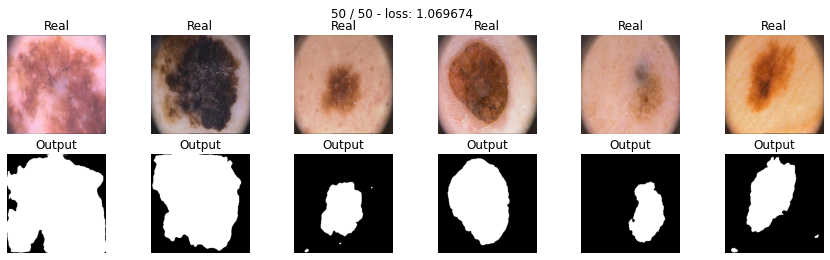

0.820000022649765
0.728000009059906
0.6520000100135803


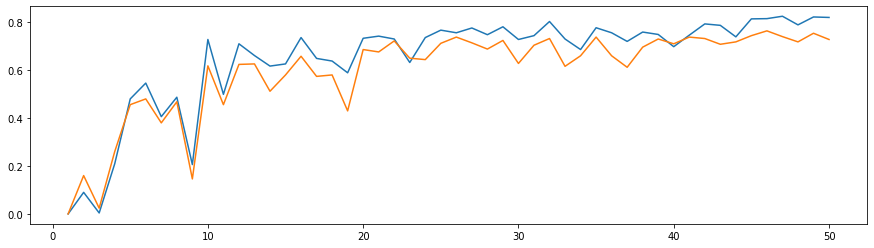

In [ ]:
# тут получаем все результаты про UNet()
model=UNet()

loss=bce_loss
name='UNet_bce'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=UNet()
loss=dice_loss
name='UNet_dice'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=UNet()
loss=focal_loss
name='UNet_focal'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=UNet()
loss=hausdorff_loss
name='UNet_hausdorff'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

In [ ]:
FILENAME = "/content/drive/My Drive/Colab Notebooks/UNet.txt"
with open(FILENAME, "w") as file:
    for name in ['UNet_bce', 'UNet_dice', 'UNet_focal', 'UNet_hausdorff']:
        file.write(str(list(train_losses[name]))+'\n')
        file.write(str(list(val_losses[name]))+'\n')
        file.write(str(list(epochs[name]))+'\n')
        file.write(str(test_losses[name])+'\n')

На этом моменте память закончилось и пришлось перезапускать, поэтому сохранение данных оказалось очень полезным для последующего сравнения

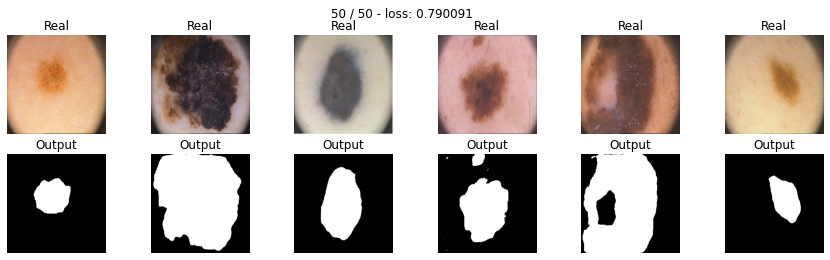

0.8009804382043726
0.7092592981126573
0.7018518911467658


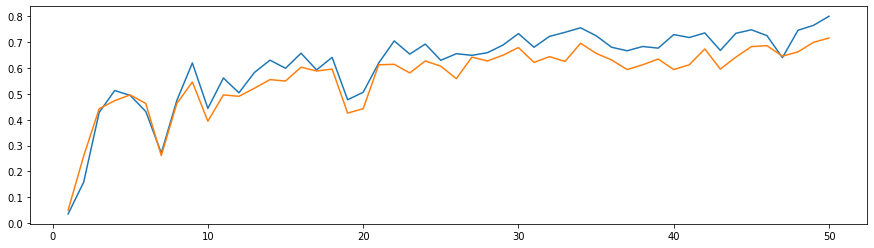

In [ ]:
# тут получаем все результаты про UNet2()
model=UNet2()

loss=bce_loss
name='UNet2_bce'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=UNet2()
loss=dice_loss
name='UNet2_dice'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=UNet2()
loss=focal_loss
name='UNet2_focal'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=UNet2()
loss=hausdorff_loss
name='UNet2_hausdorff'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

In [ ]:
FILENAME = "/content/drive/My Drive/Colab Notebooks/UNet2.txt"
with open(FILENAME, "w") as file:
    for name in ['UNet2_bce', 'UNet2_dice', 'UNet2_focal', 'UNet2_hausdorff']:
        file.write(str(list(train_losses[name]))+'\n')
        file.write(str(list(val_losses[name]))+'\n')
        file.write(str(list(epochs[name]))+'\n')
        file.write(str(test_losses[name])+'\n')

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Получим данные с google-диска.

In [27]:
import numpy as np
def parsing(a):
    a=a[1:-2]
    a=a.split(', ')
    data=np.array([])
    for i in range(len(a)):
        data=np.append(data, float(a[i]))
    return data
def get_data_from_google_disk(*names):
    train_losses={}
    val_losses={}
    epochs={}
    test_losses={}
    for name in names:
        FILENAME = "/content/drive/My Drive/Colab Notebooks/"+name+".txt"
        with open(FILENAME, "r") as file:
            for name in [name+'_bce', name+'_dice', name+'_focal', name+'_hausdorff']:
                data=file.readline()
                train_losses[name]=parsing(data)
                data=file.readline()
                val_losses[name]=parsing(data)
                data=file.readline()
                epochs[name]=parsing(data)
                data=file.readline()
                test_losses[name]=float(data)
    return train_losses, val_losses, epochs, test_losses

In [ ]:
train_losses, val_losses, epochs, test_losses = get_data_from_google_disk('SegNet', 'UNet', 'UNet2')

**ОТЧЕТ**

Так как функции потерь разные(могут отличаться с точностью до умножения на константу, например, а значит нет смысла сравнивать их значения друг с другом), поэтому будет смотреть не на них, а на метрику IoU, которую оптимизируем
Посмотрим как изменяется IoU во время обучения на наборах train и val.

***Сравнение IoU достигнутых с помощью разных лоссов для разных моделей***

**SegNet**

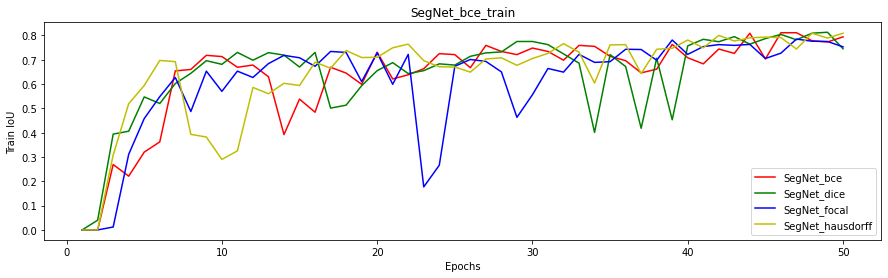

In [ ]:
plt.title('SegNet_bce_train')
plt.plot(epochs['SegNet_bce'], train_losses['SegNet_bce'], "r", label='SegNet_bce')
plt.plot(epochs['SegNet_dice'], train_losses['SegNet_dice'], "g", label='SegNet_dice')
plt.plot(epochs['SegNet_focal'], train_losses['SegNet_focal'], "b", label='SegNet_focal')
plt.plot(epochs['SegNet_hausdorff'], train_losses['SegNet_hausdorff'], "y", label='SegNet_hausdorff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Train IoU")
plt.show()

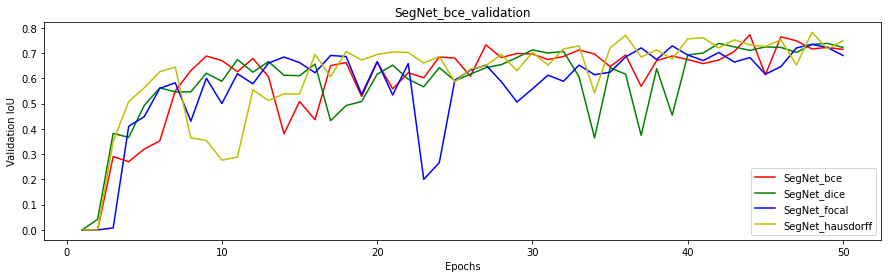

In [ ]:
plt.title('SegNet_bce_validation')
plt.plot(epochs['SegNet_bce'], val_losses['SegNet_bce'], "r", label='SegNet_bce')
plt.plot(epochs['SegNet_dice'], val_losses['SegNet_dice'], "g", label='SegNet_dice')
plt.plot(epochs['SegNet_focal'], val_losses['SegNet_focal'], "b", label='SegNet_focal')
plt.plot(epochs['SegNet_hausdorff'], val_losses['SegNet_hausdorff'], "y", label='SegNet_hausdorff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation IoU")
plt.show()

Данные графики показывает, что изменение IoU происходит достаточно сильными скачками почти весь процесс обучения как на тренировочной выборке, так и на валидационной.

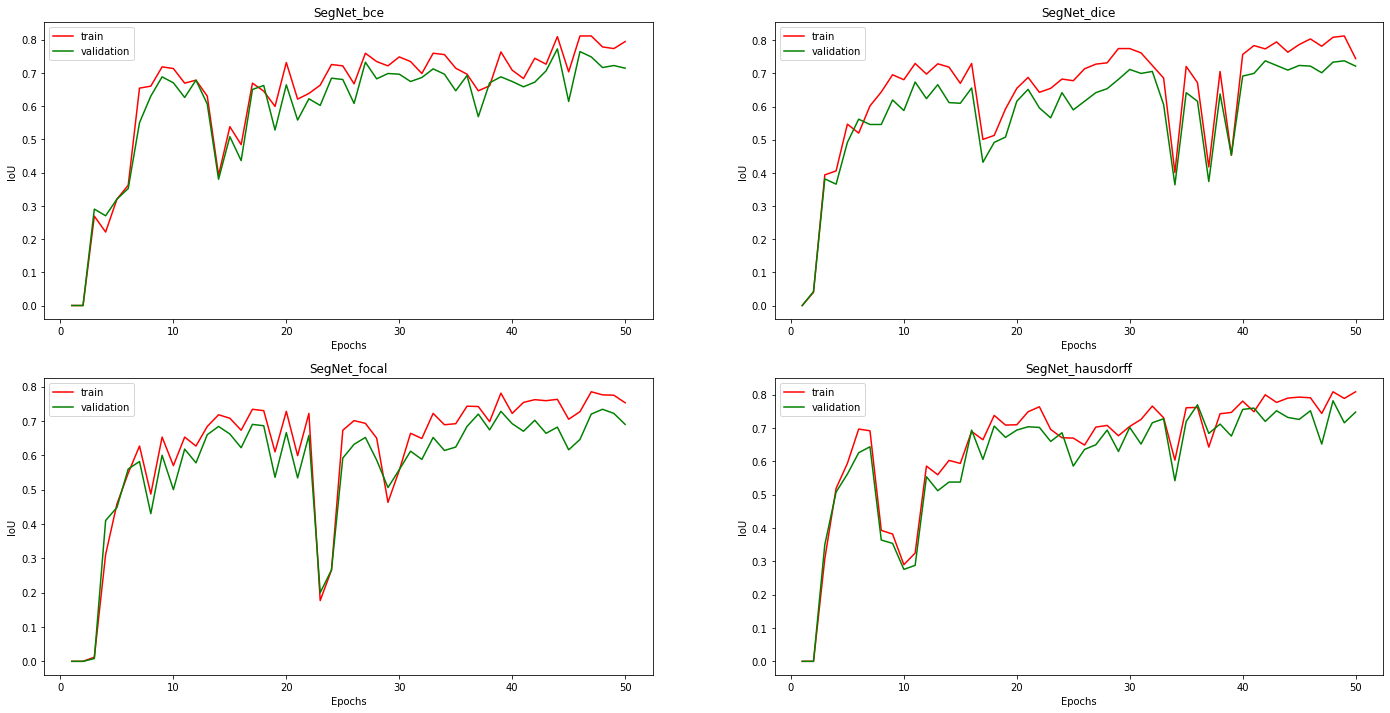

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(221)
plt.title('SegNet_bce')
plt.plot(epochs['SegNet_bce'], train_losses['SegNet_bce'], "r", label='train')
plt.plot(epochs['SegNet_bce'], val_losses['SegNet_bce'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(222)
plt.title('SegNet_dice')
plt.plot(epochs['SegNet_dice'], train_losses['SegNet_dice'], "r", label='train')
plt.plot(epochs['SegNet_dice'], val_losses['SegNet_dice'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(223)
plt.title('SegNet_focal')
plt.plot(epochs['SegNet_focal'], train_losses['SegNet_focal'], "r", label='train')
plt.plot(epochs['SegNet_focal'], val_losses['SegNet_focal'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(224)
plt.title('SegNet_hausdorff')
plt.plot(epochs['SegNet_hausdorff'], train_losses['SegNet_hausdorff'], "r", label='train')
plt.plot(epochs['SegNet_hausdorff'], val_losses['SegNet_hausdorff'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

Как можно видеть из графиков bce_loss и hausdorff_loss, более стабильны(не так резко падают вниз во время обучения) для SegNet

In [ ]:
print('SegNet_bce_IoU =',test_losses['SegNet_bce'])
print('SegNet_dice_IoU =',test_losses['SegNet_dice'])
print('SegNet_focal_IoU =',test_losses['SegNet_focal'])
print('SegNet_hausdorff_IoU =',test_losses['SegNet_hausdorff'])

SegNet_bce_IoU = 0.6740000486373902
SegNet_dice_IoU = 0.6820000410079956
SegNet_focal_IoU = 0.6380000472068786
SegNet_hausdorff_IoU = 0.6820000410079956


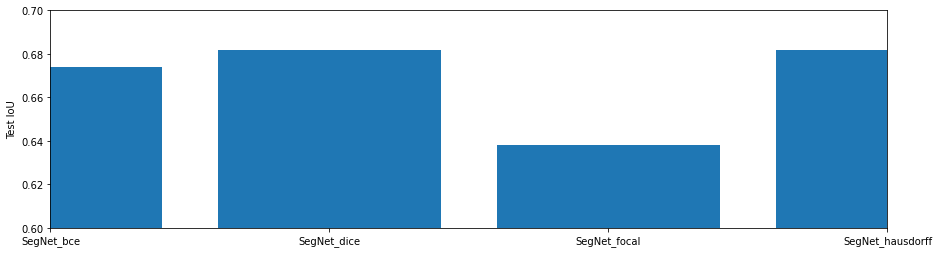

In [ ]:
plt.bar(['SegNet_bce','SegNet_dice','SegNet_focal','SegNet_hausdorff'],
        (test_losses['SegNet_bce'], test_losses['SegNet_dice'], 
         test_losses['SegNet_focal'], test_losses['SegNet_hausdorff'])
        )
plt.axis([0,3,0.6,0.7])
plt.ylabel('Test IoU')
plt.show()

Таким образом на тесте лучше оказались dice_loss и hausdorff_loss.
Подводя итог по SegNet-лучший лосс-**hausdorff_loss**

**UNet**

Посмотрим на изменению IoU во время обучения на тренировке и валидации.

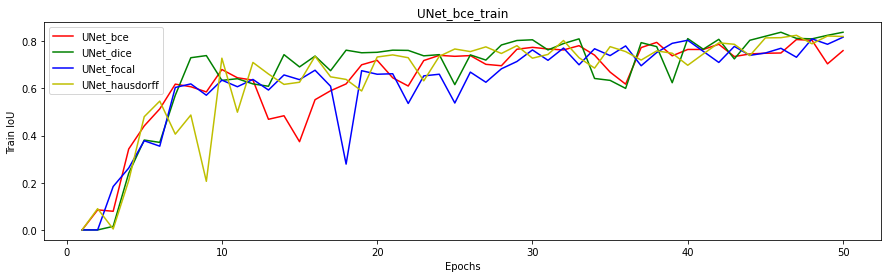

In [ ]:
plt.title('UNet_bce_train')
plt.plot(epochs['UNet_bce'], train_losses['UNet_bce'], "r", label='UNet_bce')
plt.plot(epochs['UNet_dice'], train_losses['UNet_dice'], "g", label='UNet_dice')
plt.plot(epochs['UNet_focal'], train_losses['UNet_focal'], "b", label='UNet_focal')
plt.plot(epochs['UNet_hausdorff'], train_losses['UNet_hausdorff'], "y", label='UNet_hausdorff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Train IoU")
plt.show()

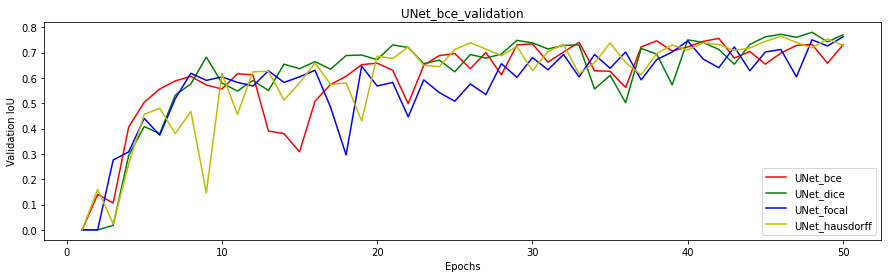

In [ ]:
plt.title('UNet_bce_validation')
plt.plot(epochs['UNet_bce'], val_losses['UNet_bce'], "r", label='UNet_bce')
plt.plot(epochs['UNet_dice'], val_losses['UNet_dice'], "g", label='UNet_dice')
plt.plot(epochs['UNet_focal'], val_losses['UNet_focal'], "b", label='UNet_focal')
plt.plot(epochs['UNet_hausdorff'], val_losses['UNet_hausdorff'], "y", label='UNet_hausdorff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation IoU")
plt.show()

У этой модели сильные скачки IoU наблюдаются только в начале-уже лучше.

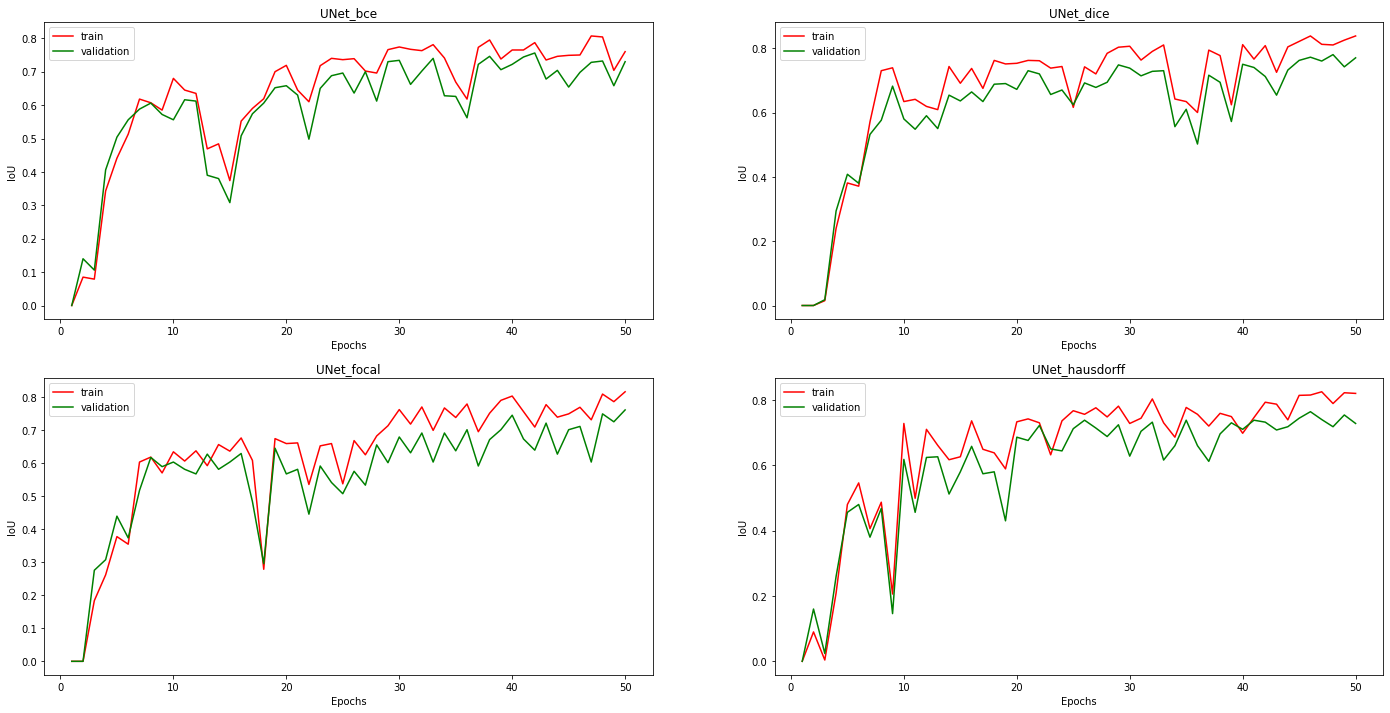

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(221)
plt.title('UNet_bce')
plt.plot(epochs['UNet_bce'], train_losses['UNet_bce'], "r", label='train')
plt.plot(epochs['UNet_bce'], val_losses['UNet_bce'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(222)
plt.title('UNet_dice')
plt.plot(epochs['UNet_dice'], train_losses['UNet_dice'], "r", label='train')
plt.plot(epochs['UNet_dice'], val_losses['UNet_dice'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(223)
plt.title('UNet_focal')
plt.plot(epochs['UNet_focal'], train_losses['UNet_focal'], "r", label='train')
plt.plot(epochs['UNet_focal'], val_losses['UNet_focal'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(224)
plt.title('UNet_hausdorff')
plt.plot(epochs['UNet_hausdorff'], train_losses['UNet_hausdorff'], "r", label='train')
plt.plot(epochs['UNet_hausdorff'], val_losses['UNet_hausdorff'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

Как видно из графиков, лучшее качество достигается при использовании dice_loss и focal_loss. При это focal_loss страдает в начале из-за сильных колебаний IoU и более менее стабилизируется при увеличении числа эпох, а dice_loss продолжает сильно колебаться и при большем числе эпох. Поэтому в данном случае focal_loss оказался лучше.

In [ ]:
print('UNet_bce_IoU =',test_losses['UNet_bce'])
print('UNet_dice_IoU =',test_losses['UNet_dice'])
print('UNet_focal_IoU =',test_losses['UNet_focal'])
print('UNet_hausdorff_IoU =',test_losses['UNet_hausdorff'])

UNet_bce_IoU = 0.6780000329017639
UNet_dice_IoU = 0.7140000462532043
UNet_focal_IoU = 0.7220000386238098
UNet_hausdorff_IoU = 0.6520000338554383


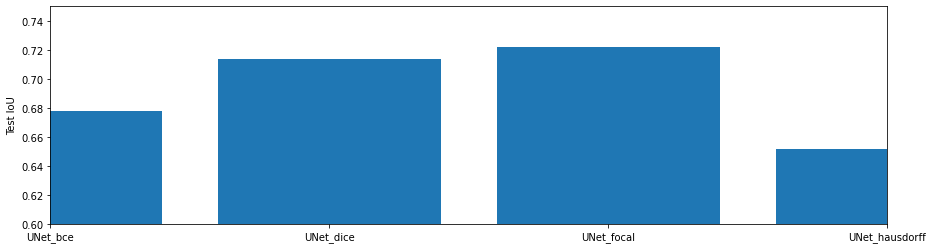

In [ ]:
plt.bar(['UNet_bce','UNet_dice','UNet_focal','UNet_hausdorff'],
        (test_losses['UNet_bce'], test_losses['UNet_dice'], 
         test_losses['UNet_focal'], test_losses['UNet_hausdorff'])
        )
plt.axis([0,3,0.6,0.75])
plt.ylabel('Test IoU')
plt.show()

Получается, что focal_loss оказался лучше и на тесте для UNet. Поэтому для данной модели лучше использовать его.

**Unet2**

Посмотрим на изменению IoU во время обучения на тренировке и валидации.

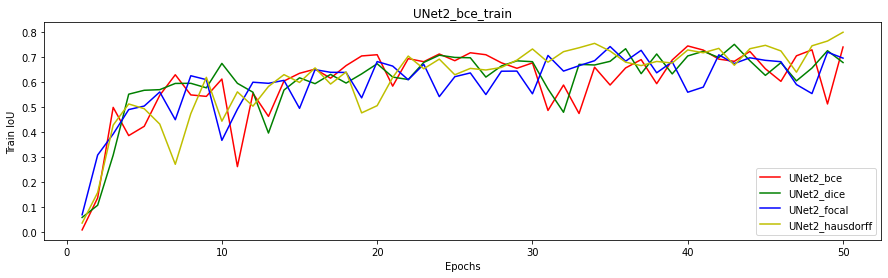

In [ ]:
plt.title('UNet2_bce_train')
plt.plot(epochs['UNet2_bce'], train_losses['UNet2_bce'], "r", label='UNet2_bce')
plt.plot(epochs['UNet2_dice'], train_losses['UNet2_dice'], "g", label='UNet2_dice')
plt.plot(epochs['UNet2_focal'], train_losses['UNet2_focal'], "b", label='UNet2_focal')
plt.plot(epochs['UNet2_hausdorff'], train_losses['UNet2_hausdorff'], "y", label='UNet2_hausdorff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Train IoU")
plt.show()

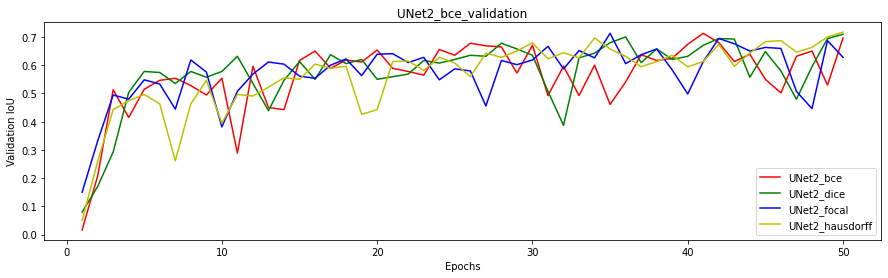

In [ ]:
plt.title('UNet2_bce_validation')
plt.plot(epochs['UNet2_bce'], val_losses['UNet2_bce'], "r", label='UNet2_bce')
plt.plot(epochs['UNet2_dice'], val_losses['UNet2_dice'], "g", label='UNet2_dice')
plt.plot(epochs['UNet2_focal'], val_losses['UNet2_focal'], "b", label='UNet2_focal')
plt.plot(epochs['UNet2_hausdorff'], val_losses['UNet2_hausdorff'], "y", label='UNet2_hausdorff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation IoU")
plt.show()

Данные графики показывает, что изменение IoU происходит достаточно сильными скачками почти весь процесс обучения как на тренировочной выборке, так и на валидационной-аналогично SegNet.

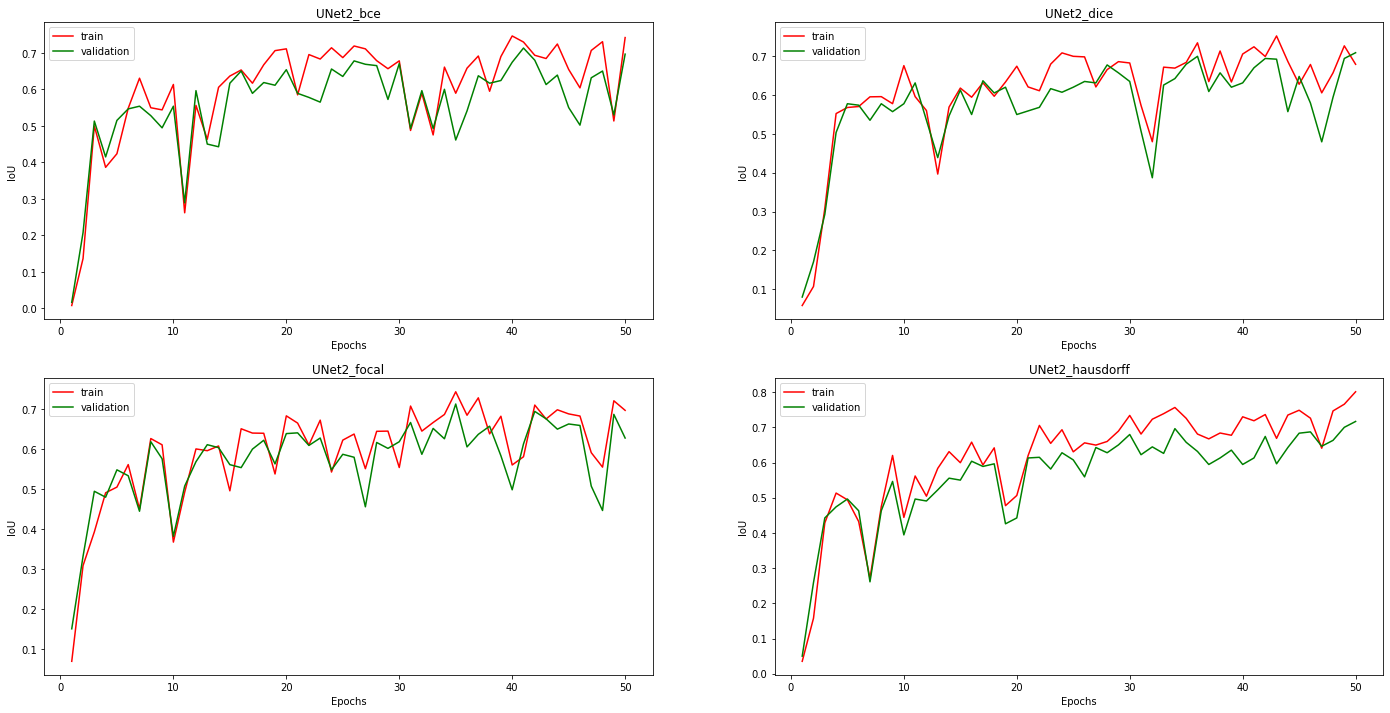

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(221)
plt.title('UNet2_bce')
plt.plot(epochs['UNet2_bce'], train_losses['UNet2_bce'], "r", label='train')
plt.plot(epochs['UNet2_bce'], val_losses['UNet2_bce'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(222)
plt.title('UNet2_dice')
plt.plot(epochs['UNet2_dice'], train_losses['UNet2_dice'], "r", label='train')
plt.plot(epochs['UNet2_dice'], val_losses['UNet2_dice'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(223)
plt.title('UNet2_focal')
plt.plot(epochs['UNet2_focal'], train_losses['UNet2_focal'], "r", label='train')
plt.plot(epochs['UNet2_focal'], val_losses['UNet2_focal'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(224)
plt.title('UNet2_hausdorff')
plt.plot(epochs['UNet2_hausdorff'], train_losses['UNet2_hausdorff'], "r", label='train')
plt.plot(epochs['UNet2_hausdorff'], val_losses['UNet2_hausdorff'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

In [ ]:
print('UNet2_bce_IoU =',test_losses['UNet2_bce'])
print('UNet2_dice_IoU =',test_losses['UNet2_dice'])
print('UNet2_focal_IoU =',test_losses['UNet2_focal'])
print('UNet2_hausdorff_IoU =',test_losses['UNet2_hausdorff'])

UNet2_bce_IoU = 0.624074078268475
UNet2_dice_IoU = 0.6703703933291965
UNet2_focal_IoU = 0.5592592822180854
UNet2_hausdorff_IoU = 0.7055555880069733


Качество не впечатляет... Однако hausdorff_loss показал достаточно не плохой результат. При этом он не так сильно колеблется по сравнению с другими лоссами.

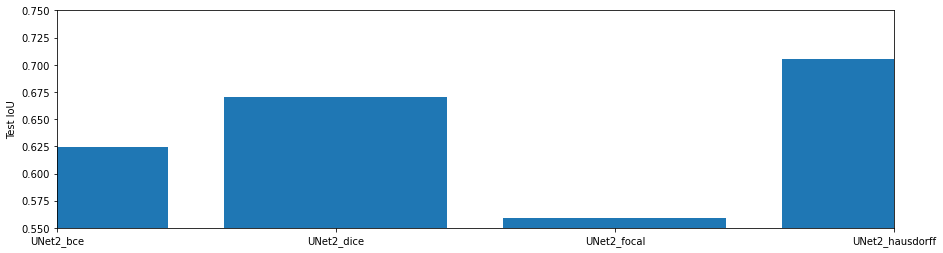

In [ ]:
plt.bar(['UNet2_bce','UNet2_dice','UNet2_focal','UNet2_hausdorff'],
        (test_losses['UNet2_bce'], test_losses['UNet2_dice'], 
         test_losses['UNet2_focal'], test_losses['UNet2_hausdorff'])
        )
plt.axis([0,3,0.55,0.75])
plt.ylabel('Test IoU')
plt.show()

Лучше качество удалось достигнуть при помощи dice_loss и hausdorff_loss, однако hausdorff_loss более стабильно растет, поэтому для UNet2 лучше использовать его.


***Сравнение моделей***

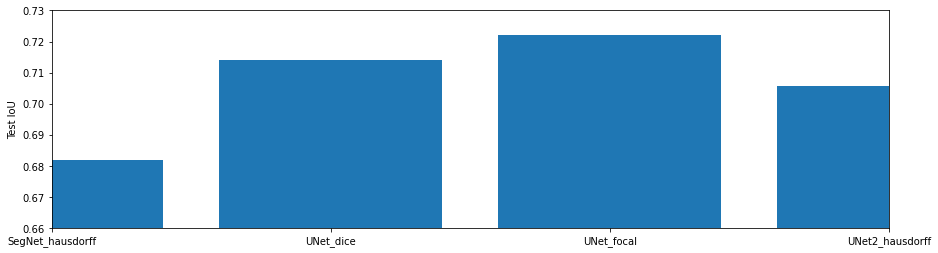

In [ ]:
plt.bar(['SegNet_hausdorff','UNet_dice','UNet_focal','UNet2_hausdorff'],
        (test_losses['SegNet_hausdorff'],test_losses['UNet_dice'], test_losses['UNet_focal'], test_losses['UNet2_hausdorff'])
        )
plt.axis([0,3,0.66,0.73])
plt.ylabel('Test IoU')
plt.show()

Лучшего результата на тесте удалось достичь с помощью моделей UNet с focal_loss и UNet с dice_loss.
Однако для двух других моделей лучшим оказался hausdorff_loss.

К сожалению, достичь IoU больше 90% не удалось, однако были исследованы в общей сложности 12 моделей (3 архитектуры с 4 вариантами лосса каждая) и среди них выбрана наиболее удачная архитектура.
UNet справился с задачей лучше и при этом процесс обучения проходил без очень сильных скачков во время обучения, что делает процесс обучения более успешным. Попробуем обучить UNet c dice_loss и focal_loss с большим количество эпох и посмотрим, станет ли лучше.

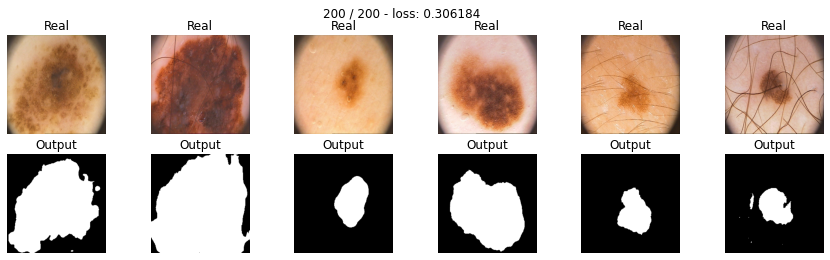

0.8955882752642912
0.7925926049550375
0.7203704118728638


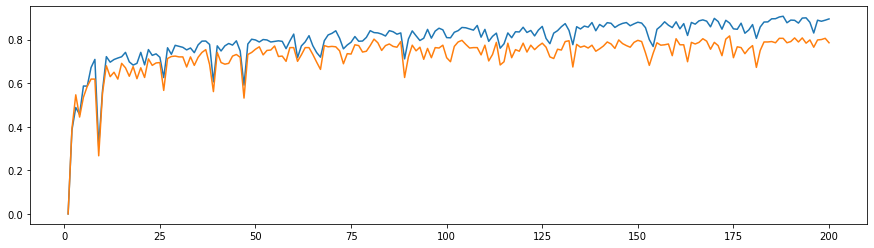

In [31]:
model=UNet()
loss=dice_loss
name='UNet_dice_200'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss, max_epochs=200)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss

model=UNet()
loss=focal_loss
name='UNet_focal_200'
model_train_losses, model_val_losses, model_epochs, model_test_loss = global_train(model, loss_function=loss, max_epochs=200)
train_losses[name]=model_train_losses
val_losses[name]=model_val_losses
epochs[name]=model_epochs
test_losses[name]=model_test_loss
FILENAME = "/content/drive/My Drive/Colab Notebooks/UNet_200.txt"
with open(FILENAME, "w") as file:
    for name in ['UNet_dice_200', 'UNet_focal_200']:
        file.write(str(list(train_losses[name]))+'\n')
        file.write(str(list(val_losses[name]))+'\n')
        file.write(str(list(epochs[name]))+'\n')
        file.write(str(test_losses[name])+'\n')

Сравним 2 лучшие модели: UNet с dice_loss и UNet с focal_loss

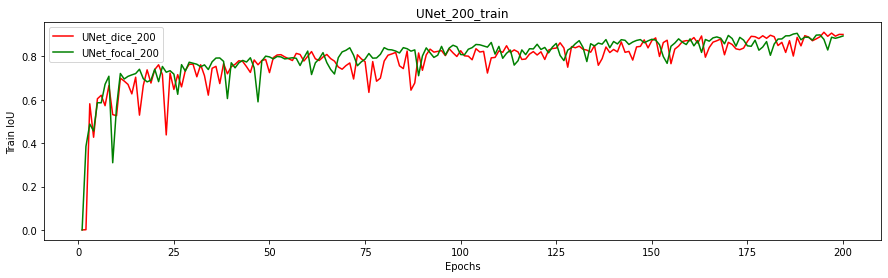

In [32]:
plt.title('UNet_200_train')
plt.plot(epochs['UNet_dice_200'], train_losses['UNet_dice_200'], "r", label='UNet_dice_200')
plt.plot(epochs['UNet_focal_200'], train_losses['UNet_focal_200'], "g", label='UNet_focal_200')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Train IoU")
plt.show()

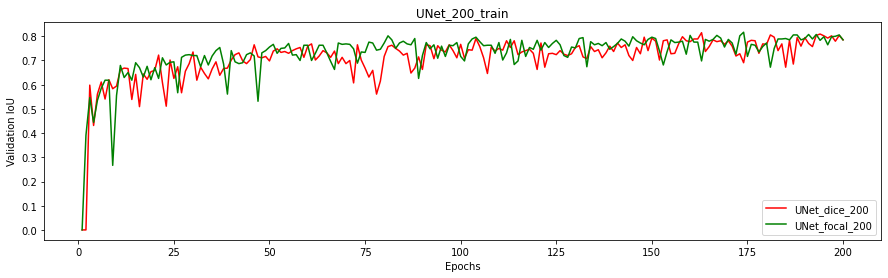

In [33]:
plt.title('UNet_200_train')
plt.plot(epochs['UNet_dice_200'], val_losses['UNet_dice_200'], "r", label='UNet_dice_200')
plt.plot(epochs['UNet_focal_200'], val_losses['UNet_focal_200'], "g", label='UNet_focal_200')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation IoU")
plt.show()

Отлично, увеличение IoU не сильно шумное

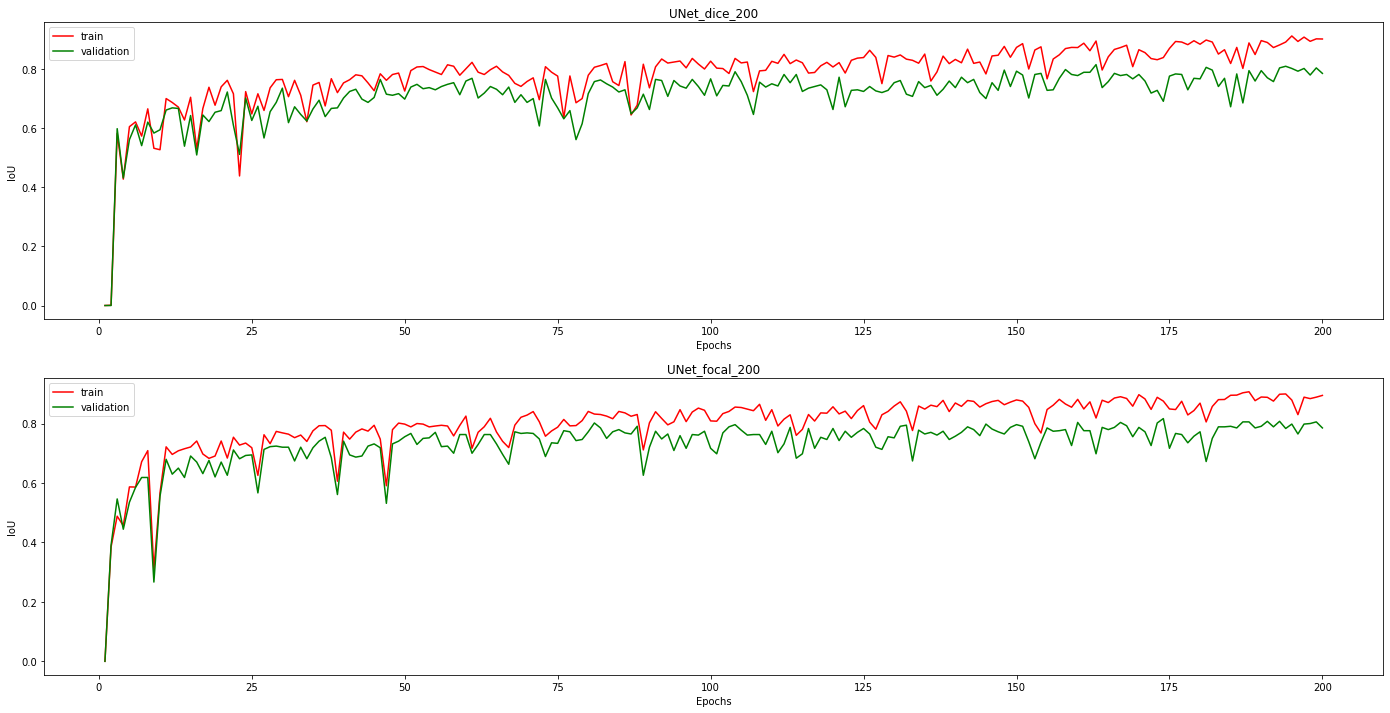

In [36]:
plt.figure(figsize=(24, 12))
plt.subplot(211)
plt.title('UNet_dice_200')
plt.plot(epochs['UNet_dice_200'], train_losses['UNet_dice_200'], "r", label='train')
plt.plot(epochs['UNet_dice_200'], val_losses['UNet_dice_200'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.subplot(212)
plt.title('UNet_focal_200')
plt.plot(epochs['UNet_focal_200'], train_losses['UNet_focal_200'], "r", label='train')
plt.plot(epochs['UNet_focal_200'], val_losses['UNet_focal_200'], "g", label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

Как было замечено ранее и видно на этих графиках, IoU растет достаточно плавно, без сильных "провалов" для обеих моделей.

Теперь посмотрим чего удалось добиться на тестовой выборке.

In [38]:
print('UNet_dice_200_IoU =', test_losses['UNet_dice_200'])
print('UNet_focal_200_IoU =', test_losses['UNet_focal_200'])

UNet_dice_200_IoU = 0.7037037412325541
UNet_focal_200_IoU = 0.7425926327705383


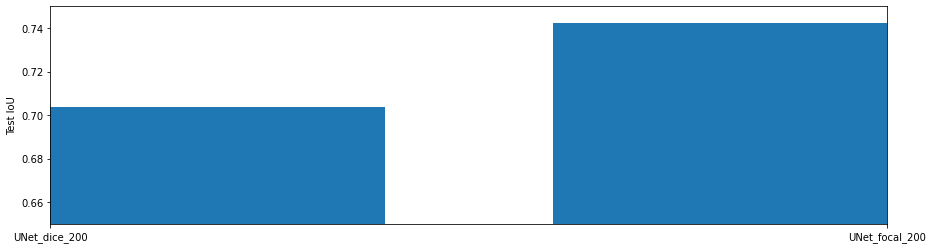

In [40]:
plt.bar(['UNet_dice_200','UNet_focal_200'],
        (test_losses['UNet_dice_200'], test_losses['UNet_focal_200']))
plt.axis([0,1,0.65,0.75])
plt.ylabel('Test IoU')
plt.show()

На тесте лучше оказался UNet c focal_loss.

***Итог***

SegNet: лучше всего работает с hausdorff_loss

Test IoU = 0.6820000410079956

UNet: лучше всего работает с focal_loss

Test IoU = 0.7425926327705383

UNet2: лучше всего работает с hausdorff_loss

Test IoU = 0.7055555880069733

Таким образом, на тесте лучше оказалась модель UNet c focal_loss, обучавшаяся 200 эпох.

Подводя итог, можно сделать вывод, что для данной задачи лучше всего подходит UNet c focal_loss, который превосходит другие модели по всем критериям (качество на тренировке, валидации, тесте, стабильность обучения (то, насколько сильно колеблется IoU во время обучения)). Хотя для достижения такого качества пришлось тренировать модель в 4 раза дольше, чем все другие, увеличение количества эпох дало возможность улучшить результат, достигнутый при 50 эпохах, хотя и не сильно(значит все модели(12 штук) не было необходимости обучать 200 эпох вместо 50, так как прирост даже для лучшей модели не очень велик).